The coverage is estimated for each sample in the new GENEWIZ samples (project 30-317737003) and compared to that for previous samples.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import subprocess
import pandas as pd
import numpy as np
import io
import re
import matplotlib.pyplot as plt
from sklearn import linear_model, neighbors, model_selection

## Preparation

Running `notebook/2020-04-29-sample-fastq-sizes/runme.sh` on Ada and invoking the `nreads_from_idxstatslist()` function in the `get_nreads.py` module produced the following tables:

In [2]:
ls ~/projects/bsm/results/2020-04-29-sample-fastq-sizes/*.tsv

/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/coverage_genewiz.tsv
/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/coverage.tsv
/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/fastq-nblocks.tsv
/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/nreads-genewiz.tsv
/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/nreads.tsv


Get the length of the reference genome

In [3]:
fai = pd.read_csv('/big/data/refgenome/GRCh37/dna/hs37d5.fa.fai', header=None, sep='\t')
hg_len_bp = fai.sum()[1]
print(hg_len_bp / 10**9, 'Gb')

3.137454505 Gb


The number of reads for the whole genome was obtained by summing over the number of mapped and unmapped reads for each contig, which in turn was obtained with `samtools idxstats` (see `get_nreads.py`).  The number of reads gave an estimate of coverage using the length of the human genome and the lenght of each read (151).

In [4]:
nreads = pd.read_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/nreads.tsv', sep='\t', index_col='sample')
nreads['coverage'] = nreads['nreads'] * 151 / hg_len_bp
nreads.tail()

,nreads,path,coverage
sample,,,
PITT_091_NeuN_mn,1040763710,/projects/bsm/alignments/PITT_091/PITT_091_Neu...,50.090071
PITT_091_NeuN_pl,3091314178,/projects/bsm/alignments/PITT_091/PITT_091_Neu...,148.779350
PITT_101_NeuN_pl,3503572864,/projects/bsm/alignments/PITT_101/PITT_101_Neu...,168.620613
PITT_118_NeuN_mn,929306289,/projects/bsm/alignments/PITT_118/PITT_118_Neu...,44.725828
PITT_118_NeuN_pl,4221676035,/projects/bsm/alignments/PITT_118/PITT_118_Neu...,203.181618


Likewise we have the number of reads from the new GENEWIZ data

In [5]:
nreads_genewiz = pd.read_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/nreads-genewiz.tsv', sep='\t', index_col='sample')
nreads_genewiz['coverage'] = nreads_genewiz['nreads'] * 151 / hg_len_bp
nreads_genewiz

,nreads,path,coverage
sample,,,
MSSM_222_NeuN_pl,914638385,/home/attila/projects/bsm/results/2020-04-29-s...,44.019888
MSSM_370_NeuN_pl,1319744493,/home/attila/projects/bsm/results/2020-04-29-s...,63.516911
MSSM_364_NeuN_pl,1263470967,/home/attila/projects/bsm/results/2020-04-29-s...,60.808568
MSSM_321_NeuN_pl,1437017192,/home/attila/projects/bsm/results/2020-04-29-s...,69.161033
PITT_117_NeuN_pl,1107187714,/home/attila/projects/bsm/results/2020-04-29-s...,53.286938
MSSM_269_NeuN_pl,1245266049,/home/attila/projects/bsm/results/2020-04-29-s...,59.932398
MSSM_027_NeuN_pl,1350034836,/home/attila/projects/bsm/results/2020-04-29-s...,64.974730
MSSM_213_NeuN_pl,1194579509,/home/attila/projects/bsm/results/2020-04-29-s...,57.492947
PITT_071_NeuN_pl,1130946579,/home/attila/projects/bsm/results/2020-04-29-s...,54.430409


In [6]:
nreads.to_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/coverage.tsv')
nreads_genewiz.to_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/coverage_genewiz.tsv')

In [7]:
nblocks = pd.read_csv('/home/attila/projects/bsm/results/2020-04-29-sample-fastq-sizes/fastq-nblocks.tsv', sep='\t')
nblocks['fq.gz size, GiB'] = nblocks['nblocks, kB'] * 2 ** -20
def fix_samplen(sname):
    newname = re.sub('(MSSM|PITT)', '\\1_', sname)
    newname = re.sub('(pl|mn)1', '\\1_', newname)
    return(newname)
nblocks['sample'] = [fix_samplen(s) for s in nblocks['sample']]
nblocks

,sample,"nblocks, kB",file path,"fq.gz size, GiB"
0,PITT_091_NeuN_pl,9021632,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,8.603699
1,PITT_091_NeuN_pl,8035760,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,7.663498
2,PITT_091_NeuN_pl,7769508,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,7.409580
3,PITT_091_NeuN_pl,8768292,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,8.362095
4,PITT_091_NeuN_pl,7779932,/projects/bsm/reads/PITT091_NeuN_pl/PITT091_Ne...,7.419521
...,...,...,...,...
2159,MSSM_109_NeuN_pl_,4391232,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.187805
2160,MSSM_109_NeuN_pl_,4934676,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.706074
2161,MSSM_109_NeuN_pl_,4306656,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.107147
2162,MSSM_109_NeuN_pl_,4960984,/projects/bsm/reads/MSSM109_NeuN_pl1/MSSM109_N...,4.731163


Now get samples present in both data frame and filter data frames for those samples.  Then sort according to `nreads`.

In [8]:
fsize = nblocks.groupby('sample').sum()
samples = set(fsize.index).intersection(nreads.index)
nreads = nreads.loc[samples, :].sort_values('nreads', ascending=False)
fsize = fsize.loc[nreads.index, :]
old = pd.concat([nreads, fsize], axis=1)[['nreads', 'coverage', 'fq.gz size, GiB']]
print(old.head(), '\n' * 2, old.tail())

                      nreads    coverage  fq.gz size, GiB
sample                                                   
MSSM_373_NeuN_pl  5126657796  246.736750       418.182316
PITT_118_NeuN_pl  4221676035  203.181618       348.390968
MSSM_215_NeuN_pl  3992458107  192.149774       323.420944
MSSM_183_NeuN_pl  3733596080  179.691214       307.038284
MSSM_369_NeuN_pl  3348853213  161.174237       272.427040 

                      nreads   coverage  fq.gz size, GiB
sample                                                 
MSSM_118_muscle   802078851  38.602602        67.163513
MSSM_183_muscle   794585616  38.241966        66.080299
MSSM_179_NeuN_mn  767418276  36.934451        63.949398
PITT_010_NeuN_mn  735747926  35.410214        61.114750
MSSM_179_muscle   656607857  31.601346        66.167599


In [9]:
slist = pd.read_csv('/home/attila/projects/bsm/results/2020-04-07-GENEWIZ-samples/sample_list.tsv', sep='\t', index_col='file_name')
p1 = subprocess.run(['aws', 's3', 'ls', 's3://chesslab-bsmn/GENEWIZ/30-317737003/'], capture_output=True)
p2 = subprocess.run(['tr', '--squeeze', '" "', ','], input=p1.stdout, capture_output=True)
newdata = pd.read_csv(io.StringIO(p2.stdout.decode('utf-8')), names=['date', 'time', 'fq.gz size, bytes', 'filename'], index_col='filename')
newdata['fq.gz size, GiB'] = newdata['fq.gz size, bytes'] / 2 ** 30
newdata = pd.concat([slist, newdata], axis=1)
new = newdata.groupby('#sample_id').sum().sort_values('fq.gz size, GiB', ascending=False)
new['coverage'] = np.nan
new.loc[nreads_genewiz.index, 'coverage'] = nreads_genewiz['coverage']
print(new.head(), '\n' * 2, new.tail())

                                                           location  date  \
#sample_id                                                                  
MSSM_027_NeuN_pl  s3://chesslab-bsmn/GENEWIZ/30-317737003/26_R1_...     0   
MSSM_352_NeuN_pl  s3://chesslab-bsmn/GENEWIZ/30-317737003/29_R1_...     0   
PITT_072_NeuN_pl  s3://chesslab-bsmn/GENEWIZ/30-317737003/32_R1_...     0   
PITT_071_NeuN_pl  s3://chesslab-bsmn/GENEWIZ/30-317737003/31_R1_...     0   
PITT_050_NeuN_pl  s3://chesslab-bsmn/GENEWIZ/30-317737003/28_R1_...     0   

                  time  fq.gz size, bytes  fq.gz size, GiB   coverage  
#sample_id                                                             
MSSM_027_NeuN_pl     0                  0                0  64.974730  
MSSM_352_NeuN_pl     0                  0                0        NaN  
PITT_072_NeuN_pl     0                  0                0        NaN  
PITT_071_NeuN_pl     0                  0                0  54.430409  
PITT_050_NeuN_pl     0      

## Analysis
### Exploration
Plot **coverage** agains Gzipped fastq size (**fq.gz size, GiB**) for each sample.  Use both linear and log scale.

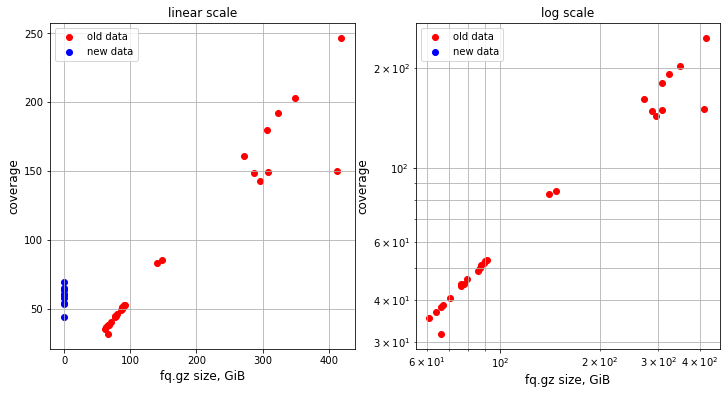

In [10]:
def myscatter(ax, scale='linear'):
    ax.scatter(old['fq.gz size, GiB'], old['coverage'], c='r', label='old data')
    ax.scatter(new['fq.gz size, GiB'], new['coverage'], c='b', label='new data')
    ax.set_xlabel('fq.gz size, GiB', fontsize='large')
    ax.set_ylabel('coverage', fontsize='large')
    ax.grid(b=True, which='both')
    #ax.grid(b=True, which='minor', linestyle=':')
    plt.xscale(scale)
    plt.yscale(scale)
    ax.set_title(scale + ' scale')
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
myscatter(ax[0], 'linear')
myscatter(ax[1], 'log')

The graph reveals a linear relationship for most samples, while some samples seem to be outliers.

### Fitting linear model

Fit linear model and evaluate squared error for each point of the training data

In [11]:
X = np.log10(np.array(old['fq.gz size, GiB']))[:, np.newaxis]
y = np.log10(np.array(old['coverage']))[:, np.newaxis]
X_new = np.log10(np.array(new['fq.gz size, GiB']))[:, np.newaxis]
y_new = np.log10(np.array(new['coverage']))[:, np.newaxis]
X_train = np.log10(np.concatenate((np.array(old['fq.gz size, GiB']), np.array(new.loc[new['coverage'].dropna().index, 'fq.gz size, GiB']))))[:, np.newaxis]
y_train =  np.log10(np.concatenate((np.array(old['coverage']), np.array(new['coverage'].dropna()))))[:, np.newaxis]
lm = linear_model.LinearRegression().fit(X_train, y_train)
y_hat = lm.predict(X)
X_fig = np.linspace(1.5, 2.7, 2)[:, np.newaxis]
y_fig = lm.predict(X_fig)
y_new_pred = lm.predict(X_new)
y_new_nona = np.log10(np.array(new['coverage'].dropna()))[:, np.newaxis]
sq_error = (y_hat[:, 0] - y[:, 0]) ** 2
sq_error_sorted = sq_error.copy()
sq_error_sorted.sort()
print(sq_error_sorted)

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Plot results:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax = axes[0]
ax.scatter(X[:, 0], y[:, 0], c='pink', edgecolor='red', marker='o', label='old data')
#ax.scatter(X[:, 0], y[:, 0], s=5*sq_error/np.median(sq_error), c='pink', edgecolor='red', marker='o', label='old data (training)')
ax.scatter(X_new[:, 0], y_new[:, 0], marker='o', c='lightblue', edgecolor='blue', label='new data')
ax.plot(X_fig[:, 0], y_fig[:, 0], label='linear model', c='g')
ax.scatter(X_new[:, 0], y_new_pred[:, 0], marker='+', c='b', s=100, label='new data (predicted)')
ax.legend(fontsize='large')
ax.set_title('Linear model and squared error\nmarker size$\propto$sq error')
ax.set_xlabel('$\log_{10} \mathrm{filesize}$', fontsize='large')
ax.set_ylabel('$\log_{10} \mathrm{coverage}$', fontsize='large')
ax.grid(b=True, which='both')
for sqe, s, xx, yy in zip(sq_error, old.index, X[:, 0], y[:, 0]):
    if sqe > 1.7e-3:
        ax.text(xx, yy, s, horizontalalignment='left', verticalalignment='center', fontsize='small')
ax = axes[1]
ax.grid(b=True, which='both', axis='y')
bp = ax.boxplot((y, y_new_nona, y_new_pred), labels=['old data', 'new data', 'new data (predicted)'])

In [ ]:
new['predicted coverage'] = 10 ** y_new_pred[:, 0]
X_old = np.array(old['coverage'])[:, np.newaxis]
X_new = np.array(new['predicted coverage'])[:, np.newaxis]
X_fig = np.linspace(0, 300, 200)[:, np.newaxis]
param_grid = {'bandwidth': np.logspace(-1, 3, 100), 'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']}
def plotter(ax, X, title):
    kde = model_selection.GridSearchCV(neighbors.KernelDensity(), param_grid=param_grid, n_jobs=-1, cv=5, refit=False)
    kde.fit(X)
    kde1 = neighbors.KernelDensity(**kde.best_params_).fit(X)
    logpdf = kde1.score_samples(X_fig)
    y_f = np.concatenate(([0], np.exp(logpdf), [0]))
    X_f = np.concatenate(([X_fig[0, 0]],  X_fig[:, 0], [X_fig[-1, 0]]))
    ax.axhline()
    ax.fill(X_f, y_f, label=title)
    ax.scatter(X[:, 0], -5e-3 + 4e-3 * np.random.random(X.shape[0]), marker='+', color='k')
    ax.set_ylabel('density', fontsize='large')
    ax.set_title(title)
    ax.axhline()
    return((kde, kde1))

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
kde_old = plotter(ax[0], X_old, 'old data')
kde_new = plotter(ax[1], X_new, 'new data (predicted)')
ax[1].set_xlabel('coverage', fontsize='large')
ax[1].set_xlim([0, 260])

In [ ]:
%connect_info